In [1]:
ROOT_PATH = "/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/MOUSE_SPLICING_FOUNDATION/MODEL_INPUT/052025/"

ATSE_DATA_PATH = ROOT_PATH + "aligned_splicing_data_20250513_035938.h5ad"
GE_DATA_PATH = ROOT_PATH + "aligned_gene_expression_data_20250513_035938.h5ad"
OUTPUT_MUDATA_PATH = ROOT_PATH + "aligned__ge_splice_combined_20250513_035938.h5mu"
REDO_JUNC_RATIO = False

print("ATSE data path:", ATSE_DATA_PATH)
print("GE data path:  ", GE_DATA_PATH)
print("Output MuData path:", OUTPUT_MUDATA_PATH)

ATSE data path: /gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/MOUSE_SPLICING_FOUNDATION/MODEL_INPUT/052025/aligned_splicing_data_20250513_035938.h5ad
GE data path:   /gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/MOUSE_SPLICING_FOUNDATION/MODEL_INPUT/052025/aligned_gene_expression_data_20250513_035938.h5ad
Output MuData path: /gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/MOUSE_SPLICING_FOUNDATION/MODEL_INPUT/052025/aligned__ge_splice_combined_20250513_035938.h5mu


In [2]:
import anndata as ad
import pandas as pd
import scipy.sparse as sp
import numpy as np
from scipy.sparse import csr_matrix, hstack, vstack
import h5py
import anndata as ad
import mudata as mu
import scanpy as sc
import scvi

In [3]:
atse_anndata = ad.read_h5ad(ATSE_DATA_PATH)
print("ATSE AnnData:", atse_anndata)

ATSE AnnData: AnnData object with n_obs × n_vars = 157418 × 34845
    obs: 'cell_id_index', 'age', 'cell_ontology_class', 'mouse.id', 'sex', 'subtissue', 'tissue', 'dataset', 'cell_name', 'cell_id', 'cell_clean', 'broad_cell_type', 'seqtech'
    var: 'junction_id', 'event_id', 'splice_motif', 'annotation_status', 'gene_name', 'gene_id', 'num_junctions', 'position_off_5_prime', 'position_off_3_prime', 'CountJuncs', 'junction_id_index'
    layers: 'cell_by_cluster_matrix', 'cell_by_junction_matrix', 'junc_ratio'


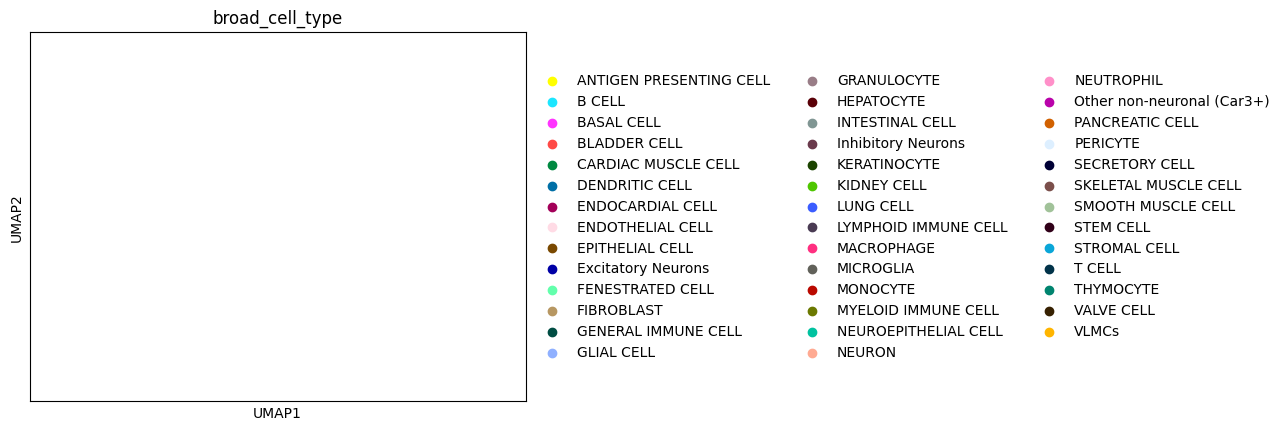

In [4]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# 1) make a 2-D dummy embedding and stick it in the 'X_umap' slot
ad = atse_anndata
rng = np.random.RandomState(0)
ad.obsm['X_umap'] = rng.rand(ad.n_obs, 2)

# 2) now call sc.pl.umap with size=0 → it will detect obsm['X_umap'] and NOT recompute anything
fig = sc.pl.umap(
    ad,
    color='broad_cell_type',
    size=0,
    legend_loc='right margin',
    show=False,
    return_fig=True,
)

# 3) display the standalone legend
plt.show()


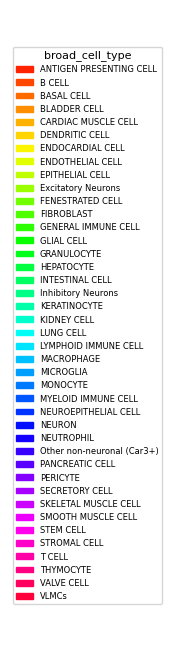

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# label you want a legend for
legend_label = 'broad_cell_type'

# pull out the exact categorical ordering you used
cats = atse_anndata.obs[legend_label].cat.categories.tolist()

# recreate the same HSV palette
palette = sns.color_palette("hsv", len(cats))

# build one Patch per category
handles = [
    mpatches.Patch(color=palette[i], label=cat)
    for i, cat in enumerate(cats)
]

# make a blank figure just to hold the legend
fig, ax = plt.subplots(figsize=(2, len(cats) * 0.2))
ax.axis('off')
ax.legend(
    handles=handles,
    title=legend_label,
    loc='center',
    frameon=True,
    fontsize=6,
    title_fontsize=8,
    ncol=1
)

# display it inline
plt.show()


In [4]:
ge_anndata = ad.read_h5ad(GE_DATA_PATH)
print("GE AnnData:", ge_anndata)

GE AnnData: AnnData object with n_obs × n_vars = 157418 × 19022
    obs: 'cell_id', 'age', 'cell_ontology_class', 'mouse.id', 'sex', 'tissue', 'dataset', 'batch', 'subtissue_clean', 'broad_cell_type', 'cell_id_index', 'cell_name', 'library_size'
    var: 'index', 'gene_name', 'gene_id', 'mean_transcript_length', 'mean_intron_length', 'num_transcripts', 'transcript_biotypes'
    obsm: 'X_library_size'
    layers: 'length_norm', 'log_norm', 'predicted_log_norm_tms', 'raw_counts'


In [ ]:
import os
import numpy as np
import scanpy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib import cm

# Constants – adjust as needed
CELL_TYPE_COLUMN = 'broad_cell_type'
TOP_N_CELLTYPES = 20
UMAP_N_NEIGHBORS = 15


def plot_umap_display(adata, rep_name, variable_name, num_groups):
    """
    Categorical UMAP highlighting the top `num_groups` in `variable_name`,
    with the figure displayed inline (no saving).
    """
    # compute graph + UMAP
    sc.pp.neighbors(adata, use_rep=rep_name, n_neighbors=UMAP_N_NEIGHBORS)
    sc.tl.umap(adata, min_dist=0.1)

    # pick top groups
    top = (
        adata.obs[variable_name]
        .value_counts()
        .head(num_groups)
        .index
        .tolist()
    )

    # label top vs Other
    adata.obs['group_highlighted'] = np.where(
        adata.obs[variable_name].isin(top),
        adata.obs[variable_name].astype(str),
        'Other',
    )

    # build a discrete palette
    cmap_mod = cm.get_cmap('tab20', len(top))
    colors = {grp: cmap_mod(i) for i, grp in enumerate(top)}
    colors['Other'] = (0.9, 0.9, 0.9, 1.0)

    # plot and display
    plt.figure(figsize=(8, 5))
    fig = sc.pl.umap(
        adata,
        color='group_highlighted',
        palette=colors,
        show=False,
        frameon=True,
        legend_loc='right margin',
        legend_fontsize=10,
        return_fig=True,
    )
    plt.title(f'UMAP by {variable_name} (Top {num_groups})')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
# --- Prepare AnnData for UMAP on the junc_ratio layer ---
# make a copy to avoid overwriting
ad = atse_anndata

# move 'junc_ratio' into the main data matrix
junc = ad.layers['junc_ratio']
ad.X = junc.toarray() if sp.issparse(junc) else junc.copy()

# (optional) transform and reduce dimensionality
sc.pp.log1p(ad)
sc.pp.pca(ad, n_comps=50, svd_solver='arpack')

# --- Generate and save UMAP ---
plot_umap_display(
    ad,
    rep_name='X',  # we're using ad.X
    variable_name=CELL_TYPE_COLUMN,
    num_groups=TOP_N_CELLTYPES
)


In [ ]:
# Gene expression UMAP (length_norm layer)
import scipy.sparse as sp
import os

# copy the GE AnnData
ad = ge_anndata.copy()

# move 'length_norm' into .X
length_norm = ad.layers['length_norm']
ad.X = length_norm.toarray() if sp.issparse(length_norm) else length_norm.copy()

# (optional) normalization & dimensionality reduction
sc.pp.log1p(ad)
sc.pp.pca(ad, n_comps=50, svd_solver='arpack')

# plot
plot_umap(
    ad,
    rep_name='X',
    variable_name='broad_cell_type',
    out_dir=os.path.join(OVERALL_DIR, 'figures'),
    num_groups=TOP_N_CELLTYPES
)
